In [570]:
from glob import glob
import pandas as pd
import numpy as np
from omegaconf import OmegaConf
from tqdm import tqdm
import logging
logger = logging.getLogger(__name__)

In [571]:
logdir = "logs/fix2_exp2"

In [572]:
def extract_results(logdir: str) -> dict:
    files = glob("**/srf_estimates.csv", root_dir=logdir, recursive=True)
    logger.warning(f"Extracting {len(files)} files that look like {files[0]}")

    results = []

    for f in tqdm(files):
        comps = f.replace("/", "_").split("_")
        family, seed, dataset, arch, strategy, backbone, *_ = comps
        expid = "_".join(comps[:-1])

        # config file
        conf_file = f.replace("srf_estimates.csv", ".hydra/config.yaml")
        # conf = OmegaConf.load(logdir + "/" + conf_file)

        # read pandas
        df = pd.read_csv(logdir + "/" + f)
        df["dataset"] = dataset
        df["family"] = family + "_" + arch + "_" + backbone
        df["seed"] = seed
        df["experiment"] = strategy
        df["arch"] = arch
        df["backbone"] = backbone
        df["expid"] = expid
        df["setup"] = dataset + "_" + family
        df["f"] = f
        df["shiftid"] = np.arange(df.shape[0])
        results.append(df)

    results = pd.concat(results)

    # obtain mse, variance, bias2 metrics
    error_metrics = results.groupby(
        ["dataset", "family", "experiment", "shiftid"]
    ).apply(_compute_metrics)
    error_metrics = (
        error_metrics.reset_index().groupby(["dataset", "family", "experiment"]).median()
    ).drop(columns=["shiftid"])

    # rank by seed too. Ranks are compute from the average mse along the curve
    curve_train_mse = (
        results.groupby(["dataset", "family", "experiment", "seed"])
        .apply(lambda x: np.abs(x["train_srf"] - x["true_train_srf"]).sum())
        .reset_index()
        .rename(columns={0: "train_mse"})
    )
    curve_test_mse = (
        results.groupby(["dataset", "family", "experiment", "seed"])
        .apply(lambda x: np.abs(x["train_srf"] - x["true_train_srf"]).sum())
        .reset_index()
        .rename(columns={0: "test_mse"})
    )
    curve_train_mse["train_rank"] = (
        curve_train_mse.groupby(["dataset", "family", "seed"])
        .rank(ascending=False)
        .train_mse
    )
    curve_test_mse["test_rank"] = (
        curve_test_mse.groupby(["dataset", "family", "seed"])
        .rank(ascending=False)
        .test_mse
    )
    ranks = curve_train_mse.merge(
        curve_test_mse, on=["dataset", "family", "seed", "experiment"]
    )

    return dict(
        results=results,
        metrics=error_metrics,
        ranks=ranks,
        # roc=roc,
        # auc=auc,
    )


def _compute_metrics(x: pd.DataFrame) -> pd.Series:
    out = dict(
        train_mse=np.abs(x["train_srf"] - x["true_train_srf"]).sum(),
        test_mse=np.abs(x["test_srf"] - x["true_test_srf"]).sum(),
        # train_bias2=(x["train_srf"].mean() - x["true_train_srf"].mean()) ** 2,
        # test_bias2=(x["test_srf"].mean() - x["true_test_srf"].mean()) ** 2,
        # train_variance=x["train_srf"].var(),
        # test_variance=x["test_srf"].var(),
    )
    return pd.Series(out.values(), index=out.keys())

In [573]:
results = extract_results(logdir)

Extracting 112 files that look like gaussian/37/sim-N_large_vcnet_vc/srf_estimates.csv
100%|██████████| 112/112 [00:00<00:00, 223.81it/s]


In [574]:
# make sure pandas does not supress rows
pd.set_option("display.max_rows", None)
results["metrics"]

train_mse  test_mse
dataset family            experiment                            
ihdp    gaussian_large_vc tresnet-clever-ps   3.062252  4.294208
                          vcnet               3.139694  4.269315
news    gaussian_large_vc tresnet-clever-ps   0.916622  1.923579
                          vcnet               0.729332  1.357611
sim-B   gaussian_large_vc tresnet-clever-ps   2.923293  3.162190
                          vcnet               2.301557  2.608081
sim-N   gaussian_large_vc tresnet-clever-ps   2.037079  2.534306
                          vcnet               2.481950  2.242494

In [575]:
r = results["results"]
ecols = [ "family", "dataset", "seed"]
r["train_error"] = r["train_srf"] - r["true_train_srf"]
r["test_error"] = r["test_srf"] - r["true_test_srf"]
df1 = r[r.experiment == "tresnet-clever-ps"][["train_error", "test_error", "shiftid"] + ecols]
df2 = r[r.experiment == "vcnet"][["train_error", "test_error", "shiftid"] + ecols]
dfd = pd.merge(df1, df2, on=["shiftid"] + ecols, suffixes=["_1", "_2"])
dfd["train_err_diff"] = dfd["train_error_1"].abs() - dfd["train_error_2"].abs()
dfd["test_err_diff"] = dfd["test_error_1"].abs() - dfd["test_error_2"].abs()
dfd = dfd.drop(columns=["train_error_1", "train_error_2", "test_error_1", "test_error_2"])
dfd["shiftid"] = dfd["shiftid"].astype(int)
dfd.head()

,shiftid,family,dataset,seed,train_err_diff,test_err_diff
0,0,gaussian_large_vc,ihdp,19,-0.003656,-0.015221
1,1,gaussian_large_vc,ihdp,19,-0.003724,-0.023266
2,2,gaussian_large_vc,ihdp,19,0.016248,-0.012910
3,3,gaussian_large_vc,ihdp,19,0.050743,0.006955
4,4,gaussian_large_vc,ihdp,19,0.066736,0.036291


In [576]:
# compute mean and standard errors
dfd.drop(columns=["seed", "shiftid"]).groupby(["family", "dataset"]).agg(["mean", "std"])

train_err_diff           test_err_diff          
                                    mean       std          mean       std
family            dataset                                                 
gaussian_large_vc ihdp         -0.005676  0.114006      0.001840  0.277882
                  news          0.009709  0.054563      0.037552  0.126785
                  sim-B         0.000106  0.069659      0.022675  0.094629
                  sim-N        -0.033916  0.140451     -0.007043  0.170752

In [577]:
dfd.drop(columns=["seed"]).groupby(["family", "dataset", "shiftid"]).agg(["mean", "std"])

train_err_diff           test_err_diff  \
                                            mean       std          mean   
family            dataset shiftid                                          
gaussian_large_vc ihdp    0            -0.001781  0.005536      0.004080   
                          1             0.000765  0.020561      0.020119   
                          2             0.001938  0.036535      0.029582   
                          3             0.004662  0.059980      0.022375   
                          4            -0.004692  0.088657      0.018004   
                          5            -0.006717  0.110647     -0.035722   
                          6            -0.009510  0.133322     -0.077628   
                          7            -0.011376  0.154771      0.010313   
                          8            -0.013702  0.176317     -0.090310   
                          9            -0.016343  0.200454      0.117583   
                  news    0            -0.002255  0.002315     -0.014735   
                          1             0.002805  0.014006     -0.005762   
                          2             0.005690  0.023213     -0.010142   
                          3             0.010464  0.027818     -0.009332   
                          4             0.020117  0.039874      0.015961   
                          5             0.021077  0.046372      0.088252   
                          6             0.012703  0.057054      0.074203   
                          7             0.005369  0.072693      0.116976   
                          8             0.007464  0.087522      0.078818   
                          9             0.013660  0.101071      0.041280   
                  sim-B   0            -0.002505  0.003419      0.016524   
                          1             0.003414  0.014109      0.019900   
                          2             0.008918  0.026284      0.015249   
                          3             0.009716  0.038695      0.026401   
                          4             0.007830  0.053124      0.037690   
                          5             0.011312  0.065563      0.033131   
                          6             0.013174  0.079232      0.013615   
                          7             0.015394  0.093117      0.024093   
                          8            -0.037164  0.100650      0.017375   
                          9            -0.029023  0.122374      0.022774   
                  sim-N   0            -0.000238  0.002230     -0.025097   
                          1            -0.016672  0.029719      0.003192   
                          2            -0.031375  0.056628      0.011465   
                          3            -0.041065  0.081087      0.021159   
                          4            -0.042773  0.103397      0.021705   
                          5            -0.033612  0.139355      0.003690   
                          6            -0.040133  0.168192     -0.021793   
                          7            -0.043644  0.193946     -0.022485   
                          8            -0.044021  0.216325     -0.029735   
                          9            -0.045624  0.237646     -0.032535   

                                             
                                        std  
family            dataset shiftid            
gaussian_large_vc ihdp    0        0.089042  
                          1        0.085301  
                          2        0.082595  
                          3        0.088273  
                          4        0.093908  
                          5        0.142935  
                          6        0.156735  
                          7        0.338441  
                          8        0.243122  
                          9        0.731067  
                  news    0        0.087136  
                          1        0.077260  
                          2        0.073199  
                          3  

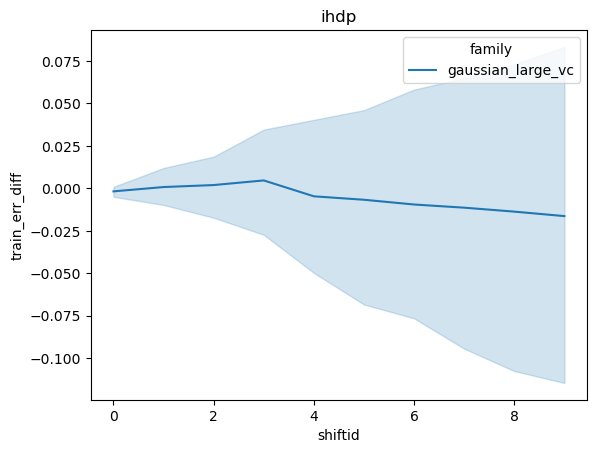

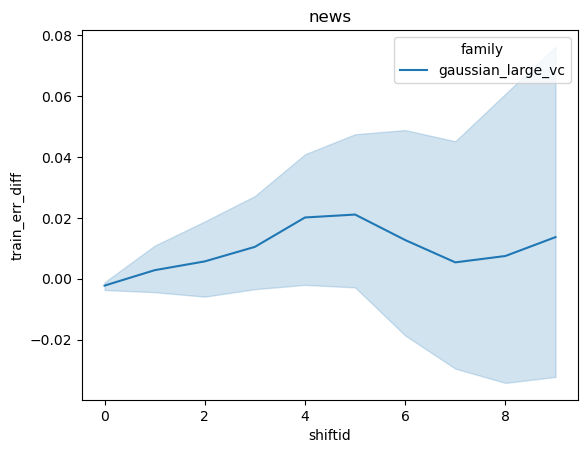

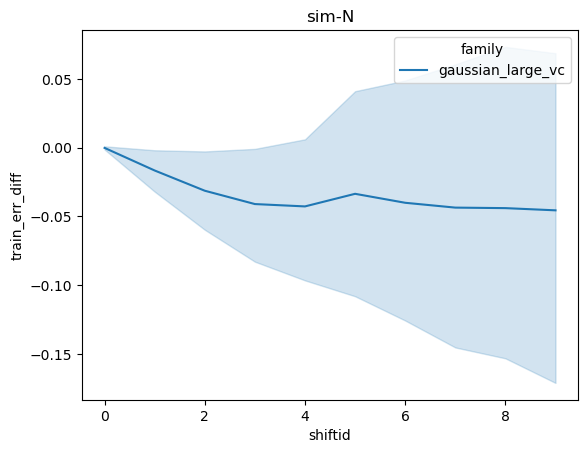

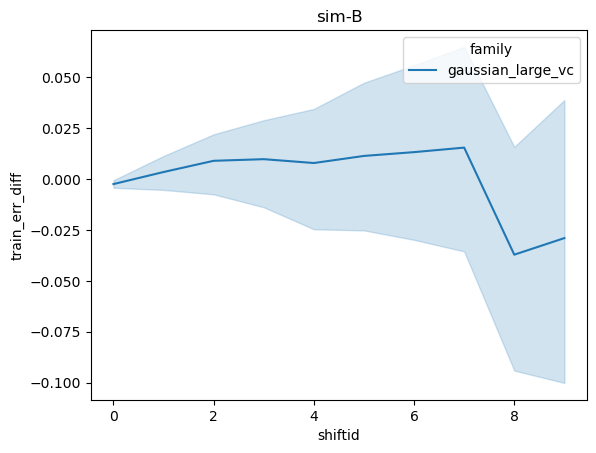

In [578]:
# make shiftid by train_err_diff plot
import seaborn as sns
import matplotlib.pyplot as plt

for d in dfd.dataset.unique():
    sdfd = dfd[dfd.dataset == d]
    sns.lineplot(
        data=sdfd,
        x="shiftid",
        y="train_err_diff",
        hue="family",
    )
    plt.title(d)
    plt.show()